<a href="https://colab.research.google.com/github/ydpajaro/Miniproyecto2/blob/main/miniproyecto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Para el sistema de Análisis Multivariado de Señales Sismográficas obtenido en el Primer Mini-Proyecto, se debe construir un módulo de variable latente utilizando el algorítmo de PCA. La idea es proyectar la matriz característica obtenida $\mathbf{X} \in \mathbb{R}^{N \times D}$, a un espacio latente de menor dimensión $q<<D$, de tal forma que los nuevos datos en este espacio sean $\mathbf{Z} \in \mathbb{R}^{N \times q}$. Selecciones diferentes configuraciones del número de componentes $q$ y evalúe el mejor desempeño arrojado por el modelo midiendo, el accuracy y la matriz de confusión. Para ellos:

  (a) Realice la visualización de las componentes en el espacio latente para diferentes configuraciones de $q$. ¿Que puede observar al respecto?

  (b) Entrene dos modelos lineales de clasificación Bayesiano y Regresión Logística, con el fin de evaluar el desempeño en el reconocimiento de los tipos de sismos tanto en el espacio de entrada (sin utilizar PCA), cómo en el espacio latente.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import numpy as np
import seaborn as sns

from ipywidgets import widgets

from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
import pandas as pd

In [4]:
#Cargamos el data set
df = pd.read_csv('/content/drive/MyDrive/miniproyecto2/datos.csv',sep = ",")
df


,energia,potencia_max,frecuencia_potencia_max,media_espectro,var_espectro,max_espectro,entropia,min_espectro,no_cero_crossing,no_mean_crossing,n5,n25,n75,n95,mediana,media,std,varianza,rms,Tipo_Sismo
0,2.453833e+01,1.215966e-04,3.90625,1.277524e-04,5.301983e-06,0.146451,5.307721e-22,9.605620,204.0,195.0,-1.532338e-02,-1.873980e-04,3.472018e-04,2.293197e-02,2.066902e-12,2.804791e-04,0.040652,1.652557e-03,1.118556e-02,sisLoc
1,8.564020e-04,2.300617e-09,39.06250,1.995403e-06,2.059800e-10,0.000409,2.412856e-25,9.605620,468.0,451.0,-1.658915e-04,-3.784440e-09,1.310257e-08,1.720937e-04,7.954222e-16,-4.570735e-07,0.000240,5.767773e-08,5.474878e-05,sisLoc
2,2.880990e-08,8.457749e-14,46.87500,1.360911e-08,6.728885e-15,0.000002,1.951416e-27,9.605620,624.0,605.0,-1.158634e-06,-1.808234e-10,8.316053e-11,1.184125e-06,-2.194506e-18,-2.630612e-09,0.000001,1.940315e-12,3.675901e-07,sisLoc
3,3.207340e+01,1.605253e-04,3.90625,1.212212e-04,6.937409e-06,0.168203,1.163691e-20,9.605620,182.0,172.0,-1.722534e-02,-3.344018e-04,1.247302e-04,1.840137e-02,-1.865526e-11,-1.025060e-04,0.046477,2.160105e-03,1.178870e-02,sisLoc
4,8.979448e-04,2.816926e-09,39.06250,1.378747e-06,2.261553e-10,0.000488,1.606779e-25,9.605620,427.0,409.0,-1.002054e-04,-3.544687e-09,1.386522e-08,1.001184e-04,9.536273e-16,3.116154e-07,0.000246,6.047571e-08,3.501850e-05,sisLoc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,1.926256e-03,2.967362e-09,31.25000,1.660664e-06,1.980359e-10,0.000472,1.728175e-31,10.373491,1170.0,1143.0,-2.037452e-04,-1.745988e-06,3.025358e-06,1.990628e-04,6.981364e-22,3.822240e-08,0.000245,6.019549e-08,7.668686e-05,SisTel
185,3.375983e-08,4.714812e-14,50.78125,7.353717e-09,3.654347e-15,0.000003,1.183745e-32,10.373491,1603.0,1575.0,-7.761713e-07,-1.743021e-08,3.027556e-08,7.490469e-07,6.110454e-24,1.371131e-10,0.000001,1.054995e-12,2.960438e-07,SisTel
186,3.892099e+01,7.931400e-05,3.90625,1.669969e-04,3.854130e-06,0.171831,1.273462e-15,10.373491,1109.0,1109.0,-2.556461e-02,-4.035743e-03,4.038336e-03,2.518270e-02,1.376711e-06,-6.915840e-06,0.034875,1.216281e-03,1.205614e-02,SisTel
187,2.440055e-03,3.053793e-09,35.15625,2.640148e-06,2.427051e-10,0.000491,3.269328e-21,10.373491,2053.0,2047.0,-3.360618e-04,-5.618561e-05,5.669137e-05,3.298703e-04,9.460301e-11,6.486854e-08,0.000276,7.625171e-08,1.266245e-04,SisTel


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   energia                  189 non-null    float64
 1   potencia_max             189 non-null    float64
 2   frecuencia_potencia_max  189 non-null    float64
 3   media_espectro           189 non-null    float64
 4   var_espectro             189 non-null    float64
 5   max_espectro             189 non-null    float64
 6   entropia                 189 non-null    float64
 7   min_espectro             189 non-null    float64
 8   no_cero_crossing         189 non-null    float64
 9   no_mean_crossing         189 non-null    float64
 10  n5                       189 non-null    float64
 11  n25                      189 non-null    float64
 12  n75                      189 non-null    float64
 13  n95                      189 non-null    float64
 14  mediana                  1

In [6]:
X = df.iloc[:, :-1].values
y = df['Tipo_Sismo'].values

interactive(children=(Dropdown(description='n_components', options=(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

<function __main__.plot_pca(n_components)>

<Figure size 640x480 with 0 Axes>

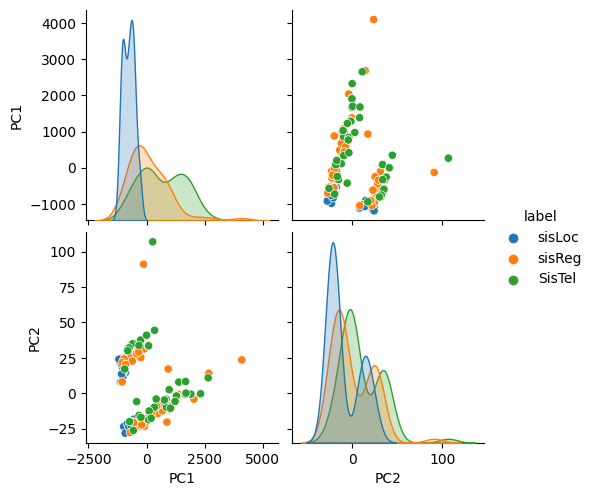

In [7]:
def plot_pca(n_components):
  # crea el objeto PCA y establce el número de componentes a utilizar
  pca = PCA(n_components=n_components)

  #Aplica PCA a los datos normalizados
  X_pca = pca.fit_transform(X)

  # Transformar los datos al espacio latente
  X_latent = pca.transform(X)

  #Convertir los datos transformados a un Dataframe
  column_names = ['PC{}'.format(i+1) for i in range(n_components)]
  column_names.append('label')
  df_latent = pd.DataFrame(np.column_stack((X_pca,df.iloc[:,-1].values)),columns = column_names)

  # Agregar la etiqueta al DataFrame
  df_latent['label'] = df.iloc[:,-1].values

  # Limpia la figura actual
  plt.clf()

  # Visualizar con pairplot
  sns.pairplot(df_latent,hue='label')

  #Crear widget interactivo 
widgets.interact(plot_pca,n_components = np.arange(2,20,1))

In [19]:
def train_test_split_and_fit(X_col,test_size):
  X_train, X_test, y_train, y_test = train_test_split(X[:,:X_col], y, test_size=test_size,random_state=40)
  # Entrenar el clasificador Bayesiano
  clfNB = GaussianNB()
  clfNB.fit(X_train, y_train) # para entrenar enviamos el conjunto de Entrenamiento
  # Entrenar el clasificador de Regresión Logística
  clfLR = LogisticRegression(random_state=0)
  clfLR.fit(X_train, y_train) # para entrenar enviamos el conjunto de Entrenamiento
  
  yPredTest_NB = clfNB.predict(X_test)
  yPredTest_LR= clfLR.predict(X_test)

  accTest_NB = accuracy_score(y_test,yPredTest_NB)
  accTest_LR = accuracy_score(y_test,yPredTest_LR)
  
  print('Acc para el modelo Bayesiano: ',accTest_NB)  
  print('Acc para el modelo de Regresión Logística: ',accTest_LR)

  cmNB = confusion_matrix(y_test, yPredTest_NB)
  disp = ConfusionMatrixDisplay(confusion_matrix=cmNB, display_labels = df['Tipo_Sismo'].unique())
  disp.plot()
  plt.title('Matriz Confusión NB')
  plt.show()

  cmLR = confusion_matrix(y_test, yPredTest_LR)
  disp = ConfusionMatrixDisplay(confusion_matrix=cmLR,display_labels = df['Tipo_Sismo'].unique())
  disp.plot()
  plt.title('Matriz Confusión LR')
  plt.show()


X_col_widget = widgets.IntSlider(value=7,
    min=0,
    max=X.shape[1],
    step=1,
    description='Componentes:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d')

test_size_widget = widgets.FloatSlider(value=0.3,
    min=0.1,
    max=0.5,
    step=0.1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',)

interactive_func = widgets.interactive(train_test_split_and_fit,X_col=X_col_widget,test_size =test_size_widget)
display(interactive_func)

interactive(children=(IntSlider(value=7, continuous_update=False, description='Componentes:', max=19), FloatSl…

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=40)

In [10]:
# Entrenar el clasificador Bayesiano
clfNB = GaussianNB()
clfNB.fit(X_train, y_train) # para entrenar enviamos el conjunto de Entrenamient

# Entrenar el clasificador de Regresión Logística
clfLR = LogisticRegression(random_state=0)
clfLR.fit(X_train, y_train) # para entrenar enviamos el conjunto de Entrenamient

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

## Evaluacion del Desempeño

1. Accuracy score
2. Confussion Matrix

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

yPredTest_NB = clfNB.predict(X_test)
yPredTest_LR= clfLR.predict(X_test)

accTest_NB = accuracy_score(y_test,yPredTest_NB)
accTest_LR = accuracy_score(y_test,yPredTest_LR)

print('Acc para el modelo Bayesiano: ',accTest_NB)
print('Acc para el modelo de Regresión Logística: ',accTest_LR)

Acc para el modelo Bayesiano:  0.9473684210526315
Acc para el modelo de Regresión Logística:  0.8070175438596491


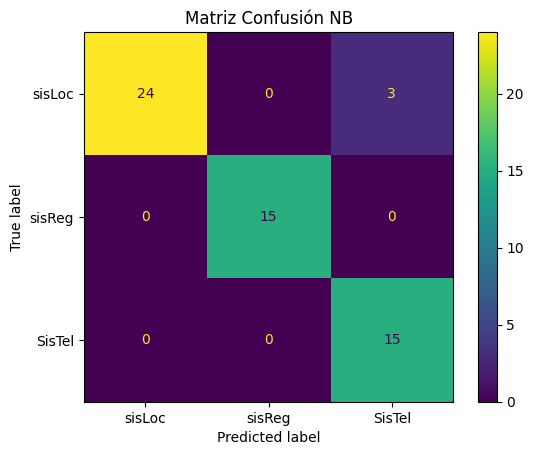

In [12]:
import matplotlib.pyplot as plt
cmNB = confusion_matrix(y_test, yPredTest_NB)
disp = ConfusionMatrixDisplay(confusion_matrix=cmNB, display_labels = df['Tipo_Sismo'].unique())
disp.plot()
plt.title('Matriz Confusión NB')
plt.show()

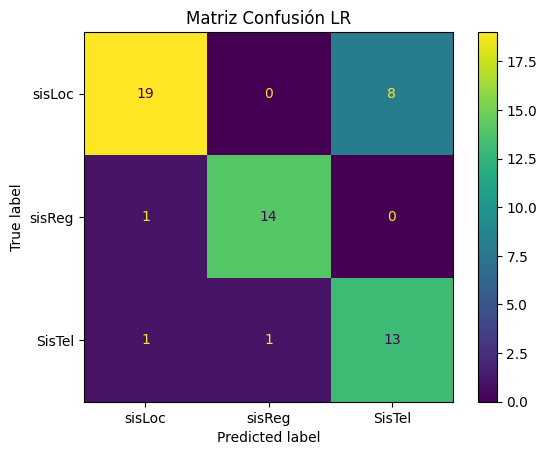

In [13]:
import matplotlib.pyplot as plt
cmLR = confusion_matrix(y_test, yPredTest_LR)
disp = ConfusionMatrixDisplay(confusion_matrix=cmLR,display_labels = df['Tipo_Sismo'].unique())
disp.plot()
plt.title('Matriz Confusión LR')
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA